In [3213]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import math

from sklearn.metrics import mean_absolute_error, mean_squared_error

### Setup of Washington COVID Data

In [3214]:
states_data = pd.read_csv('us-states.csv')

In [3215]:
wa_data = states_data[states_data['state']=='Washington'].copy().reset_index(drop = True)

In [3216]:
wa_data.head(10)

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Washington,53,1,0
4,2020-01-25,Washington,53,1,0
5,2020-01-26,Washington,53,1,0
6,2020-01-27,Washington,53,1,0
7,2020-01-28,Washington,53,1,0
8,2020-01-29,Washington,53,1,0
9,2020-01-30,Washington,53,1,0


In [3217]:
wa_data.dtypes

date      object
state     object
fips       int64
cases      int64
deaths     int64
dtype: object

In [3218]:
wa_data['date'] = pd.to_datetime(wa_data['date'])

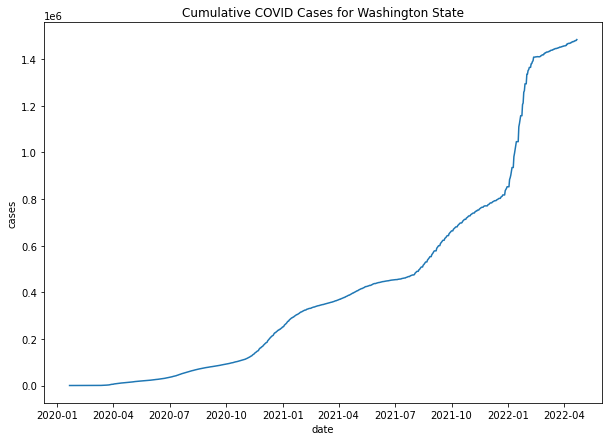

In [3219]:
fig, ax = plt.subplots(figsize=(10, 7))

p = sns.lineplot(x='date', y='cases', data=wa_data)
p.set(title="Cumulative COVID Cases for Washington State")
plt.show()

In [3220]:
wa_dates = wa_data['date'].to_numpy()
wa_total_cases = wa_data['cases'].to_numpy()
wa_new_cases = np.zeros(wa_total_cases.shape)

for i in range(len(wa_total_cases)):
    if i == 0:
        wa_new_cases[i] = wa_total_cases[i]
    else:
        wa_new_cases[i] = wa_total_cases[i] - wa_total_cases[i-1]

wa_infected = np.zeros(wa_total_cases.shape)
wa_recovered = np.zeros(wa_total_cases.shape)

for i in range(len(wa_total_cases)):
    if i >= 13:
        recovered = sum(wa_new_cases[:i-13])
    else:
        recovered = 0
        
    wa_infected[i] = wa_total_cases[i] - recovered
    wa_recovered[i] = recovered

### Set Input Parameters

In [3221]:
### Parameters to Vary ###

# lambda: number of people that a susceptible person interacts with per time step
# p: probability of getting infected if a susceptible person interacts with an infectious person
# gamma: recovery rate (recovery probability within one time step)
lam, p, gamma = 3, 0.05, 1./14 # set lam = 2 vs 20, p = 0.3, gamma = 1/14

# probability of getting infected every time step
#beta = 1 - pow(1-p,lam)
beta = min(1, lam * p) # beta <= 1 by definition

In [3222]:
### Fixed Parameters ###

# Total population. (Washington 2020)
N_total = 7705281

# Some vaccinated people are immune
N = N_total

# A grid of time points (in days) for the detecting period
t = np.linspace(0, len(wa_dates)-1, len(wa_dates))

# Initial number of infected and immune individuals, I0 and R0.
I0, R0 = 2, 0

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# Initial conditions vector
y0 = S0, I0, R0

### Time-Dependent R_0

In [3223]:
# The SIR model differential equations.
def deriv_dynamic(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta(t) * S * I / N
    dIdt = beta(t) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [3224]:
def R_0_dynamic(t):
    value = None
    for i in range(len(epochs)):
        if t >= epochs[i]:
            value = logistic_R_0(t, k[i], x[i], R_0[i],  R_0[i+1])
    return value

def logistic_R_0(t, k, x, start, end):
    return (start - end) / (1 + np.exp(-k * (-t + x))) + end

def beta_dynamic(t):
    return R_0_dynamic(t) * gamma

In [3225]:
def abse(pred, true):
    sum = 0
    for i in range(len(true)):
        sum += abs(true[i] - pred[i]) 
    
    return sum / len(true)

def rmse(pred, true):
    sum = 0
    for i in range(len(true)):
        sum += math.pow(true[i] - pred[i], 2)
    
    return math.sqrt(sum / len(true))


### Minimizing MAE

In [3227]:
# Define epoch start dates
epochs = [0, 185, 330, 400, 520, 590, 690, 740]

# R0 values for each epoch
R_0 = [1.73, 0.51, 1.66, 0.6, 1, 1.46, 0.97, 2.38, 0.04]

# k and x values for smooth R0 transition function
# k describes how fast R_0 change. Larger  𝑘  means faster change.
k = [0.07, 0.01, 0.03, 0.05, 0.08, 0.11, 0.01, 0.51]

# x is the inflection point of the transition, i.e., the day that  
# 𝑅0  changes most dramatically. You can interpret is the main lockdown day.
x = [180, 230, 310, 360, 440, 540, 610, 730]

In [3228]:
ret = odeint(deriv_dynamic, y0, t, args = (N, beta_dynamic, gamma))
S, I, R = ret.T

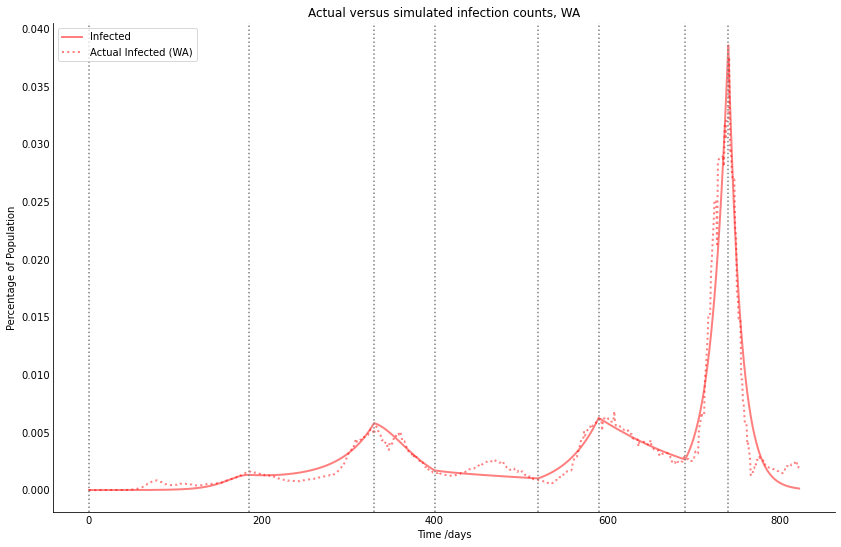

In [3229]:
# Plot the data on predicted and actual infections 

fig, ax = plt.subplots(facecolor='w', figsize = (14, 9))

ax.plot(t, I/N_total, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, wa_infected/N_total, 'r:', alpha=0.5, lw=2, label='Actual Infected (WA)')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for e in epochs:
    plt.axvline(x=e, color="grey", linestyle=':')
legend = ax.legend()
legend.get_frame().set_alpha(0.75)
for spine in ('top', 'right'):#, 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.title("Actual versus simulated infection counts, WA")
plt.show()

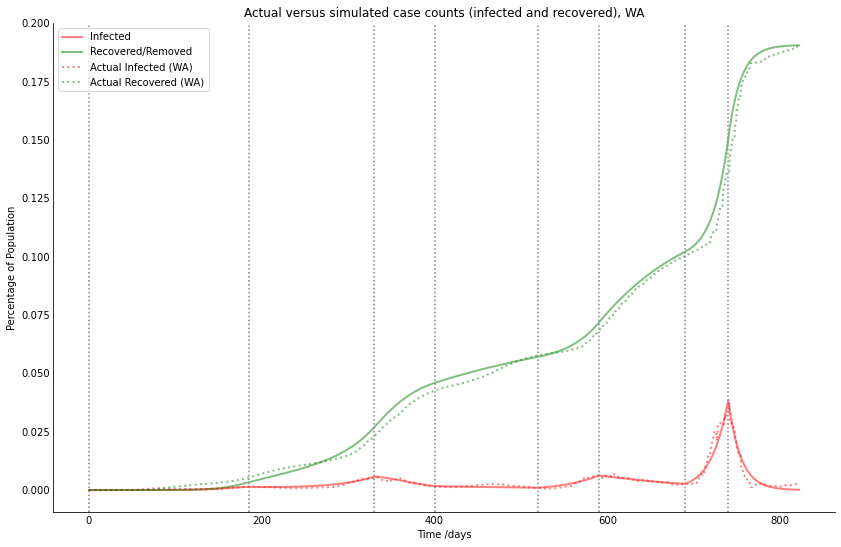

In [3230]:
# Plot the data for predicted and actual infections and recoveries

fig, ax = plt.subplots(facecolor='w', figsize = (14, 9))

ax.plot(t, I/N_total, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N_total, 'g', alpha=0.5, lw=2, label='Recovered/Removed')
ax.plot(t, wa_infected/N_total, 'r:', alpha=0.5, lw=2, label='Actual Infected (WA)')
ax.plot(t, wa_recovered/N_total, 'g:', alpha=0.5, lw=2, label='Actual Recovered (WA)')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for e in epochs:
    plt.axvline(x=e, color="grey", linestyle=':')
legend = ax.legend()
legend.get_frame().set_alpha(0.75)
for spine in ('top', 'right'):#, 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.title("Actual versus simulated case counts (infected and recovered), WA")
plt.show()

In [3231]:
print(f"Abolute Error: {mean_absolute_error(wa_infected, I)}")

Abolute Error: 5235.212801940419


### RMSE

In [3232]:
# Define epoch start dates
epochs = [0, 185, 330, 400, 520, 590, 690, 740]

# R0 values for each epoch
R_0 = [1.73, 0.51, 1.66, 0.6, 1, 1.46, 0.97, 2.38, 0.04]

# k and x values for smooth R0 transition function
# k describes how fast R_0 change. Larger  𝑘  means faster change.
k = [0.07, 0.01, 0.03, 0.05, 0.08, 0.11, 0.01, 0.51]

# x is the inflection point of the transition, i.e., the day that  
# 𝑅0  changes most dramatically. You can interpret is the main lockdown day.
x = [180, 230, 310, 360, 440, 540, 610, 730]

In [3233]:
ret = odeint(deriv_dynamic, y0, t, args = (N, beta_dynamic, gamma))
S, I, R = ret.T

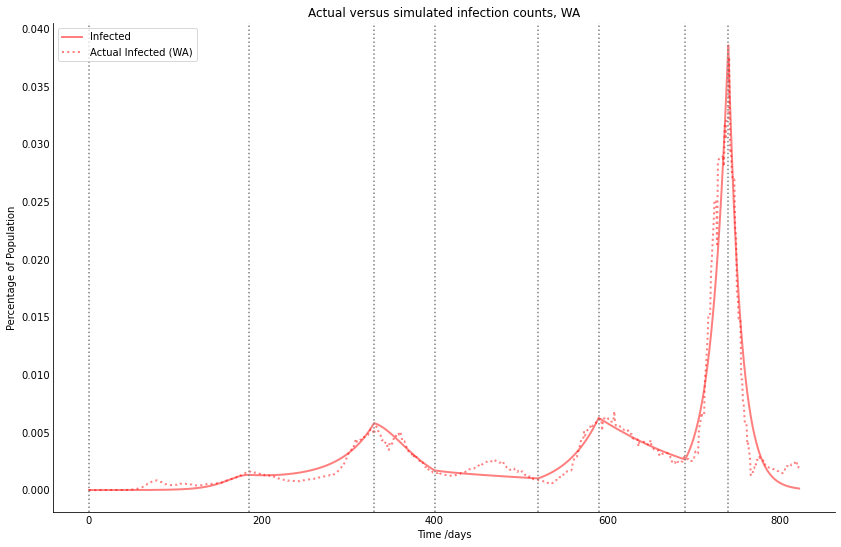

In [3234]:
# Plot the data on predicted and actual infections 

fig, ax = plt.subplots(facecolor='w', figsize = (14, 9))

ax.plot(t, I/N_total, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, wa_infected/N_total, 'r:', alpha=0.5, lw=2, label='Actual Infected (WA)')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for e in epochs:
    plt.axvline(x=e, color="grey", linestyle=':')
legend = ax.legend()
legend.get_frame().set_alpha(0.75)
for spine in ('top', 'right'):#, 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.title("Actual versus simulated infection counts, WA")
plt.show()

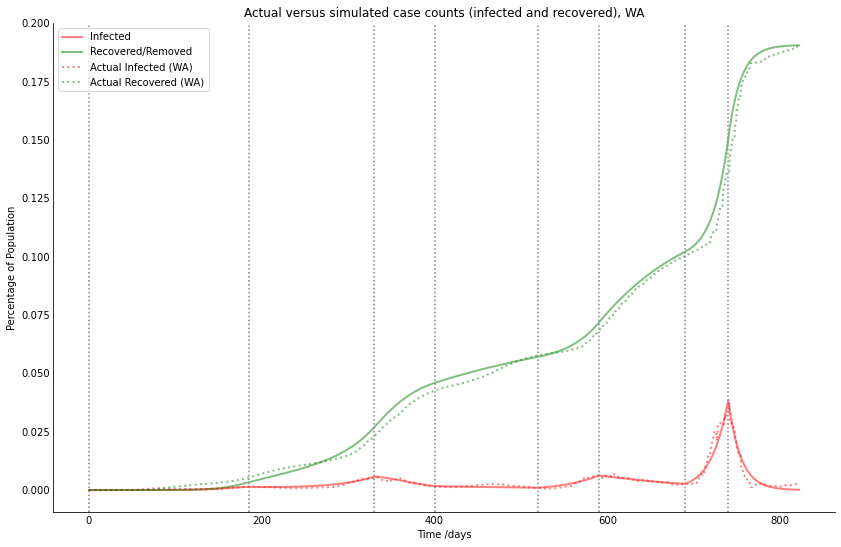

In [3235]:
# Plot the data for predicted and actual infections and recoveries

fig, ax = plt.subplots(facecolor='w', figsize = (14, 9))

ax.plot(t, I/N_total, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N_total, 'g', alpha=0.5, lw=2, label='Recovered/Removed')
ax.plot(t, wa_infected/N_total, 'r:', alpha=0.5, lw=2, label='Actual Infected (WA)')
ax.plot(t, wa_recovered/N_total, 'g:', alpha=0.5, lw=2, label='Actual Recovered (WA)')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for e in epochs:
    plt.axvline(x=e, color="grey", linestyle=':')
legend = ax.legend()
legend.get_frame().set_alpha(0.75)
for spine in ('top', 'right'):#, 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.title("Actual versus simulated case counts (infected and recovered), WA")
plt.show()

In [3236]:
print(f"RMSE: {mean_squared_error(wa_infected, I, squared=False)}")

RMSE: 9528.06563978601
